In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:5


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 9

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 1000)
GT S-parameters shape:  (10, 2, 1000)
Y S-parameters shape:  (10, 2, 132)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1000,)
Y frequencies shape:  (132,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  10.0
Mean frequency spacing:  20020020.01001001
STD frequency spacing:  28.29311577575365
Mode frequency spacing:  20020020.0
Number of samples with non-equal spacing:  501


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1000
N_SPARAMS:  10


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 1000])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 1000])


## Plot some stuff

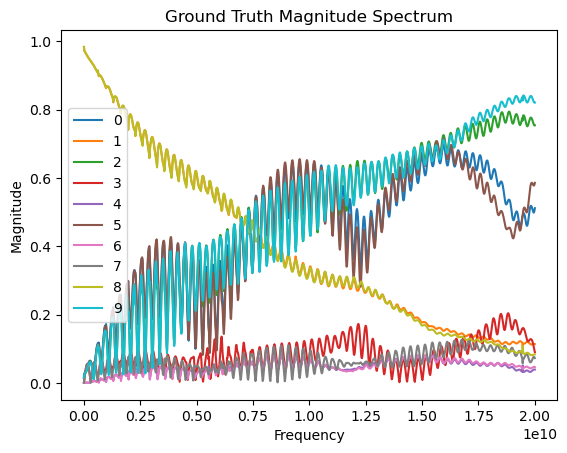

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

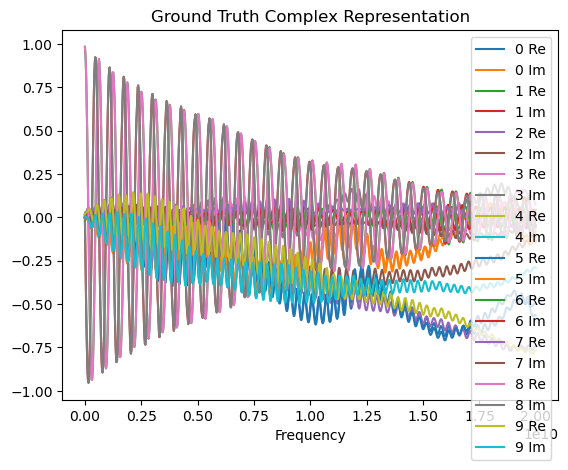

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 132

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True


print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  1000
Number of Measurements:  132
Undersampling Ratio:  0.132
[  0   7  22  38  53  68  83  99 114 129 144 160 175 190 205 221 236 251
 266 282 297 312 327 343 358 373 388 404 419 434 449 465 480 495 510 526
 541 556 571 587 602 617 632 648 663 678 693 709 724 739 754 770 785 800
 815 831 846 861 876 892 907 922 937 953 968 983 999]
[  0   7  15  22  30  38  45  53  61  68  76  83  91  99 106 114 122 129
 137 144 152 160 167 175 183 190 198 205 213 221 228 236 244 251 259 266
 274 282 289 297 305 312 320 327 335 343 350 358 366 373 381 388 396 404
 411 419 427 434 442 449 457 465 472 480 488 495 503 510 518 526 533 541
 549 556 564 571 579 587 594 602 610 617 625 632 640 648 655 663 671 678
 686 693 701 709 716 724 732 739 747 754 762 770 777 785 793 800 808 815
 823 831 838 846 854 861 869 876 884 892 899 907 915 922 930 937 945 953
 960 968 976 983 991 999]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 67])
y_freqs shape:  (67,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


Net output shape:  torch.Size([1, 20, 1000])


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  349384


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
CURR_ITER = FIRST_ITER

NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

START_LR = LR
END_LR = 1e-5
LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)


train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)


    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(x.shape)
        print(outputs.shape)
        abs_differences = torch.square(torch.subtract(x[0], outputs))

        # Sum to go to [1000]
        abs_differences = torch.mean(abs_differences, dim=0)
        print(abs_differences)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(abs_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(abs_differences, len(abs_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  70.39728450775146
NOISE LEVEL:  0.9999539493585035

ITER  999
TIME:  95.80127835273743
NOISE LEVEL:  0.9549925860214311

ITER  1999
TIME:  125.60465455055237
NOISE LEVEL:  0.9120108393558993

ITER  2999
TIME:  155.63401794433594
NOISE LEVEL:  0.8709635899560662

ITER  3999
TIME:  185.5440936088562
NOISE LEVEL:  0.8317637711026543

ITER  4999
TIME:  214.35833311080933
NOISE LEVEL:  0.7943282347242605

ITER  5999
TIME:  244.563884973526
NOISE LEVEL:  0.7585775750291576

ITER  6999
TIME:  273.9427571296692
NOISE LEVEL:  0.7244359600749617

ITER  7999
TIME:  301.1794910430908
NOISE LEVEL:  0.691830970918906

ITER  8999
TIME:  330.9442529678345
NOISE LEVEL:  0.6606934480075611

ITER  9999
TIME:  356.8150999546051
NOISE LEVEL:  0.6309573444801552

ITER  10999
TIME:  382.6268582344055
NOISE LEVEL:  0.6025595860743173

ITER  11999
TIME:  408.38165402412415
NOISE LEVEL:  0.5754399373371156

ITER  12999
TIME:  434.27125215530396
NOISE LEVEL:  0.5495408738575812

ITER  13999
TIME: 

In [23]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([455, 20, 1000])
torch.Size([20, 1000])
torch.Size([20, 1000])


## Plot metrics and outputs

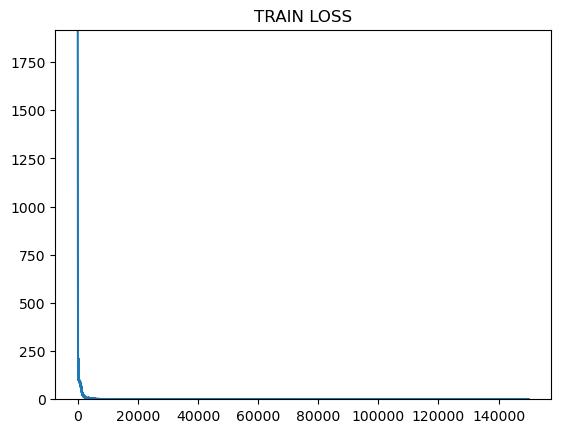

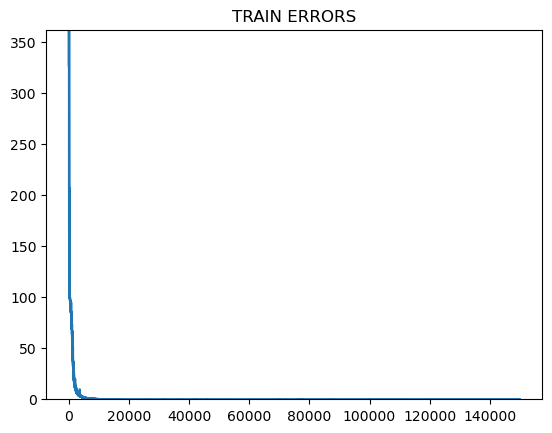

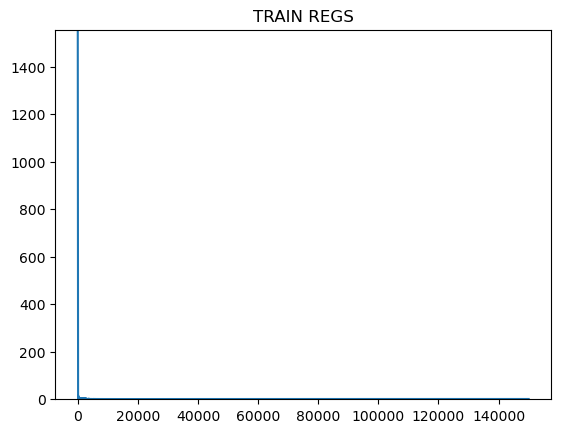

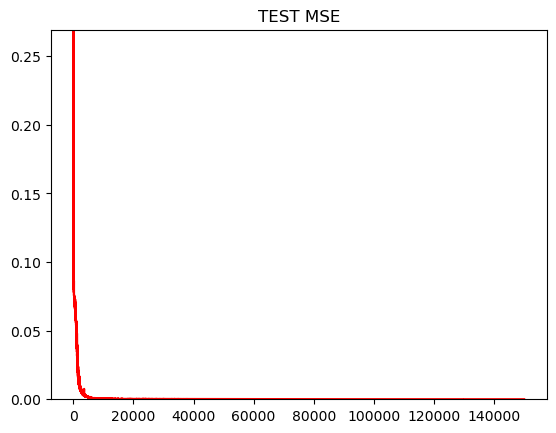

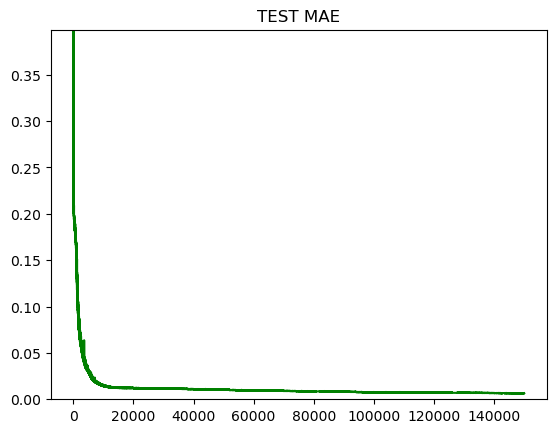

In [24]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [25]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  7.236486271722242e-05
Best Test MSE:  7.04405247233808e-05
Best Test MSE Iteration:  148430


In [26]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case09/case09.s4p
[1.00000000e+01 2.00200300e+07 1.40140150e+08 3.00300310e+08
 4.40440450e+08 5.80580590e+08 7.60760770e+08 9.00900910e+08
 1.06106107e+09 1.20120121e+09 1.36136137e+09 1.54154155e+09
 1.66166167e+09 1.76176177e+09 1.84184185e+09 1.96196197e+09
 1.98198199e+09 2.08208209e+09 2.14214215e+09 2.28228229e+09
 2.32232233e+09 2.42242243e+09 2.58258259e+09 2.62262263e+09
 2.72272273e+09 2.88288289e+09 2.92292293e+09 3.02302303e+09
 3.08308309e+09 3.20320321e+09 3.24324325e+09 3.32332333e+09
 3.40340341e+09 3.50350351e+09 3.58358359e+09 3.64364365e+09
 3.70370371e+09 3.80380381e+09 3.88388389e+09 3.94394395e+09
 4.02402403e+09 4.10410411e+09 4.20420421e+09 4.26426427e+09
 4.34434435e+09 4.42442443e+09 4.54454455e+09 4.64464465e+09
 4.72472473e+09 4.84484485e+09 4.88488489e+09 5.02502503e+09
 5.16516517e+09 5.20520521e+09 5.32532533e+09 5.48548549e+09
 5.64564565e+09 5.76576577e+09 5.82582583e+09 5.94594595e+09
 6.06606607e+09 6.146

/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)
/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.24438230507075787 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.14217563904821873 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 was not subtantially better than 2 (err 1.4495083443251013 vs 1.2901307440522949)
Performing fit with 3 poles.


/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 133142281328468.52). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.4111982751637697 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.5454140200274094 vs 1.2901307440522949)
Performing fit with 4 poles.
  Fitting took 0.6343217920511961 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 was not subtantially better than 2 (err 1.6953358501938605 vs 1.2901307440522949)
Fit completed in 1.717252254486084, using 4, resulting in a fit with 2 and error=1.2901307440522949 vs samples and error=1.4186421402282068 vs ground truth.
(1000, 4, 4)
complex128
torch.Size([1, 20, 1000])


/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 133178787738165.88). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


In [27]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([1000, 4, 4, 2])
torch.Size([1000, 4, 4, 2])
torch.Size([132, 4, 4, 2])
(1000, 4, 4, 2)
(1000, 4, 4, 2)
(10, 2, 1000)
(10, 2, 1000)
float32
float32
DIP PSNR:       47.42532230814191
VF PSNR:        19.62439571217991
Final DIP MSE:  7.236486271722242e-05
VF MSE:         0.04361344501376152
Mean DIP MSE:  7.239772094180807e-05


(1000,)
torch.Size([20, 1000])
torch.Size([1, 20, 1000])
torch.Size([1, 20, 132])
torch.Size([1, 20, 1000])
torch.Size([1, 20, 1000])


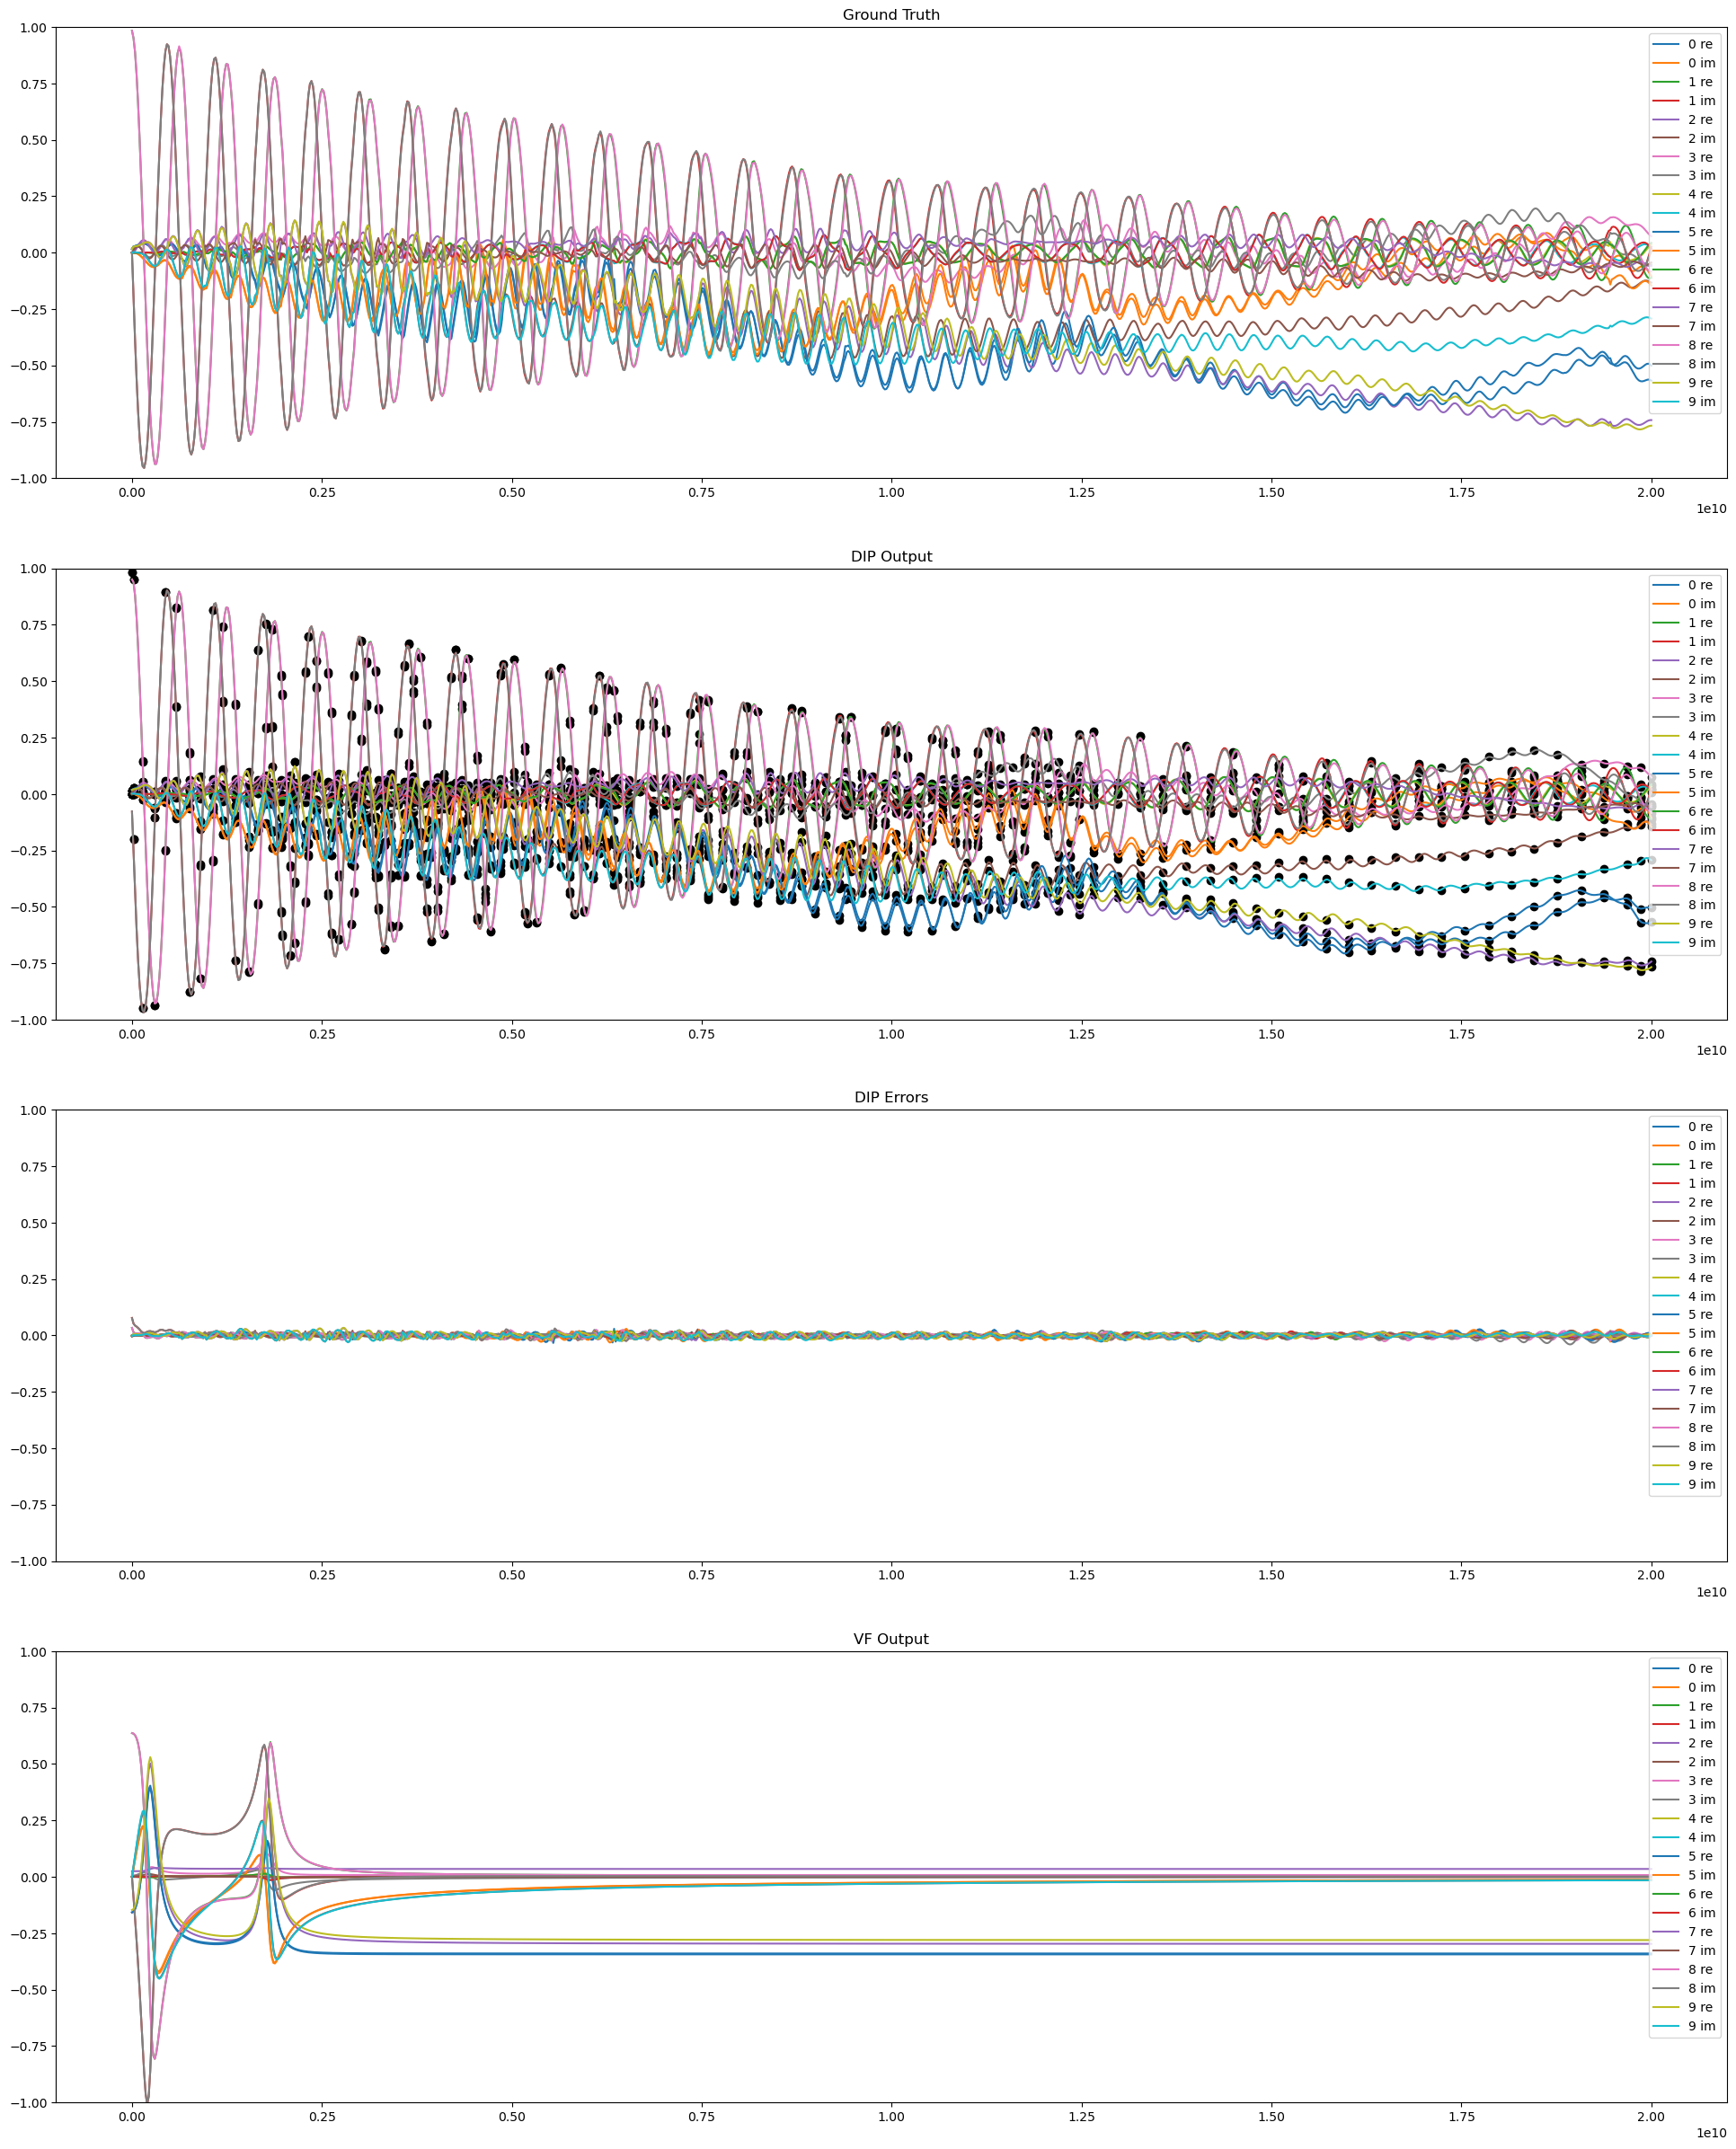

In [28]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [29]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[1.9938e-04, 1.9230e-04, 1.8414e-04, 1.6976e-04, 1.3770e-04, 1.3000e-04,
         1.0072e-04, 6.4379e-05, 6.4191e-05, 6.5781e-05, 7.1879e-05, 7.4091e-05,
         7.7768e-05, 7.8421e-05, 7.9196e-05, 8.0274e-05, 6.0475e-05, 6.2453e-05,
         4.5961e-05, 4.0376e-05, 4.0417e-05, 4.9032e-05, 7.9886e-05, 1.0607e-04,
         1.4829e-04, 1.7579e-04, 1.7888e-04, 1.9390e-04, 2.2309e-04, 2.3110e-04,
         2.2860e-04, 2.0566e-04, 1.8932e-04, 1.7482e-04, 1.4354e-04, 1.2801e-04,
         1.1341e-04, 1.0362e-04, 9.6422e-05, 9.0848e-05, 9.2384e-05, 9.2091e-05,
         7.7325e-05, 6.4100e-05, 5.9000e-05, 6.7616e-05, 9.3400e-05, 9.0971e-05,
         8.2223e-05, 8.6360e-05, 9.4886e-05, 1.0924e-04, 1.3259e-04, 1.6505e-04,
         1.7834e-04, 1.6977e-04, 1.9475e-04, 1.8627e-04, 1.8555e-04, 1.7984e-04,
         2.2013e-04, 1.8766e-04, 1.9232e-04, 1.9318e-04, 2.0717e-04, 2.3163e-04,
         2.0814e-04, 1.8151e-04, 1.4106e-04, 1.1522e-04, 1.0337e-04, 8.8918e-05,
         7.1141e-05, 5.5158e

In [30]:
print(dip_errors[-1])

tensor([[-2.2096e-03,  5.0129e-03,  4.4533e-03,  4.3280e-03,  4.7321e-03,
          4.4474e-03,  3.9139e-03,  3.4646e-03,  3.8371e-03,  4.7324e-03,
          5.8791e-03,  6.5524e-03,  6.2993e-03,  5.1267e-03,  3.5515e-03,
          2.2532e-03,  2.1096e-03,  4.8470e-04,  1.8899e-04,  4.1200e-04,
          1.4002e-04,  3.4203e-04,  1.4993e-03,  1.2118e-03,  3.2295e-03,
          5.3010e-03,  6.6906e-03,  6.5249e-03,  5.6063e-03,  4.3120e-03,
          2.9281e-03,  2.0734e-03,  9.9217e-04, -2.5185e-03, -6.3696e-03,
         -5.1084e-03, -3.6452e-03, -2.4266e-03, -4.3012e-04,  1.6520e-03,
          4.6507e-03,  7.2184e-03,  8.9715e-03,  9.0165e-03,  7.7016e-03,
          4.9010e-03,  3.3743e-03,  2.0711e-03,  4.9471e-03, -8.4100e-03,
         -9.1883e-03, -7.6455e-03, -5.6204e-03, -3.8175e-03, -1.8644e-03,
          1.7066e-03,  5.6618e-03,  8.8069e-03,  1.0058e-02,  9.4237e-03,
          7.4676e-03,  5.8148e-03,  3.6111e-03,  1.4872e-03,  2.0738e-03,
         -8.7367e-03, -1.1876e-02, -9.

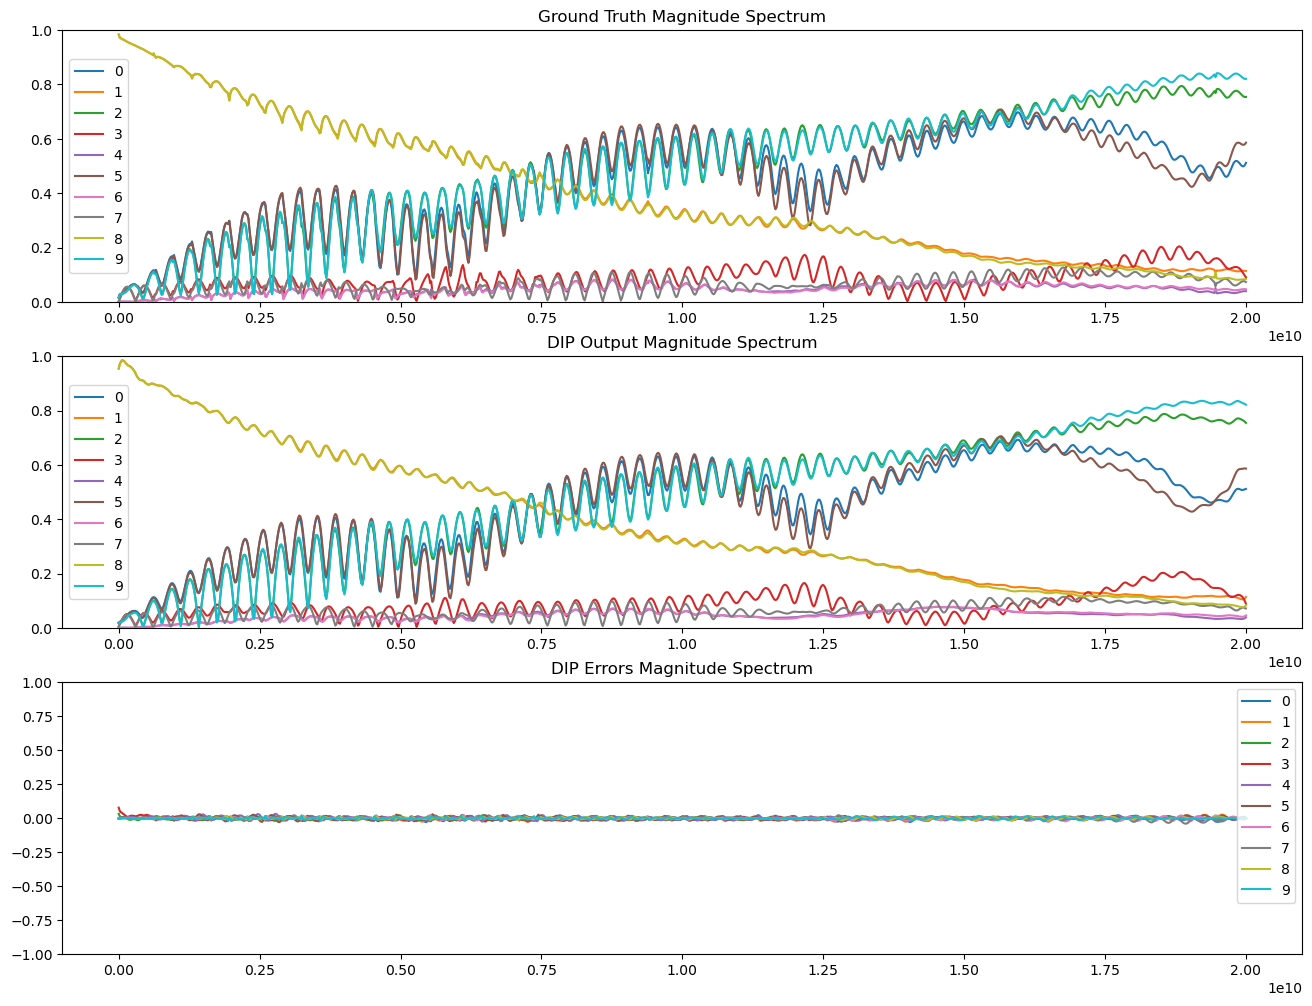

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
print(kept_inds)

[  0   1   7  15  22  29  38  45  53  60  68  77  83  88  92  98  99 104
 107 114 116 121 129 131 136 144 146 151 154 160 162 166 170 175 179 182
 185 190 194 197 201 205 210 213 217 221 227 232 236 242 244 251 258 260
 266 274 282 288 291 297 303 307 312 317 319 327 334 343 351 358 367 373
 379 388 396 404 411 419 426 434 440 449 456 465 469 473 480 487 495 502
 510 518 526 533 541 549 556 563 571 579 587 594 602 609 617 623 632 648
 663 678 693 709 724 739 754 770 785 800 815 831 846 861 876 892 907 922
 937 953 968 983 992 999]
